# `Chest X-Ray Pneumonia Detection`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

## 1) Importing the Dataset

In [2]:
labels = ["PNEUMONIA", "NORMAL"]
img_size = 150


def get_training_data(data_dir):

    data = []
    for label in labels:
        
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):

            try:
                img_arr = cv2.imread(os.path.join(
                    path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])

            except Exception as e:
                print(e)

    return np.array(data)

In [3]:
train = get_training_data("./chest_xray/train/")
test = get_training_data("./chest_xray/test/")

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



C:\Users\Admin\AppData\Local\Temp\ipykernel_2220\135780900.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


#### Stored like: [[image, label], [image, label], [image, label], ...]

## 2) EDA & Data Preprocessing

Text(0.5, 1.0, 'NORMAL')

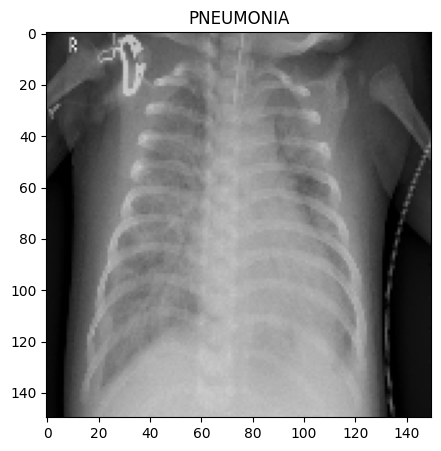

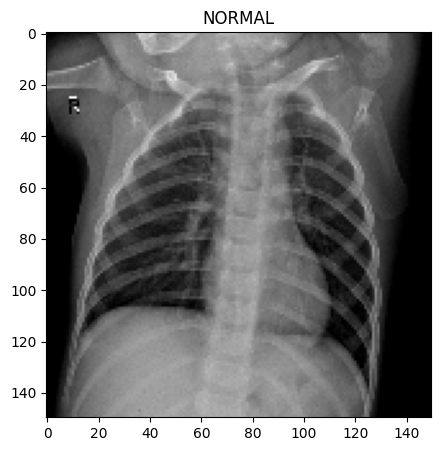

In [4]:
plt.figure(figsize=(5, 5))
plt.imshow(train[0][0], cmap="gray")
plt.title(labels[train[0][1]])

plt.figure(figsize=(5, 5))
plt.imshow(train[-1][0], cmap="gray")
plt.title(labels[train[-1][1]])

In [5]:
X_train = []
y_train = []

X_test = []
y_test = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

### Grayscale Normalization

In [6]:
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255

### Resizing Data

In [7]:
X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## 3) Building the Model

### Model Architecture

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding='same',
          activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())

model.add(MaxPool2D((2, 2), strides=2, padding='same'))

model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))

### Compiling the Model

In [9]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [11]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor="accuracy", patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [12]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=10,
                    callbacks=[learning_rate_reduction])

Epoch 1/4
164/164 [==============================] - 22s 65ms/step - loss: 0.4176 - accuracy: 0.8897 - lr: 0.0010
Epoch 2/4
164/164 [==============================] - 10s 61ms/step - loss: 0.1439 - accuracy: 0.9541 - lr: 0.0010
Epoch 3/4
164/164 [==============================] - 10s 62ms/step - loss: 0.1014 - accuracy: 0.9658 - lr: 0.0010
Epoch 4/4
164/164 [==============================] - 10s 61ms/step - loss: 0.0772 - accuracy: 0.9759 - lr: 0.0010


## 4) Evaluating the Model

In [13]:
print("Loss of the model is - ", model.evaluate(X_test, y_test)[0])
print("Accuracy of the model is - ", model.evaluate(X_test, y_test)[1]*100, "%")

20/20 [==============================] - 1s 16ms/step - loss: 14.2542 - accuracy: 0.6442
Loss of the model is -  14.254220962524414
20/20 [==============================] - 0s 16ms/step - loss: 14.2542 - accuracy: 0.6442
Accuracy of the model is -  64.42307829856873 %


In [14]:
predictions = model.predict(X_test) > 0.5
predictions = predictions.reshape(1, -1)[0]
predictions[:10]

20/20 [==============================] - 1s 14ms/step


array([False, False, False, False, False, False, False, False, False,
       False])

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[390   0]
 [222  12]]
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       390
           1       1.00      0.05      0.10       234

    accuracy                           0.64       624
   macro avg       0.82      0.53      0.44       624
weighted avg       0.77      0.64      0.52       624



<AxesSubplot: >

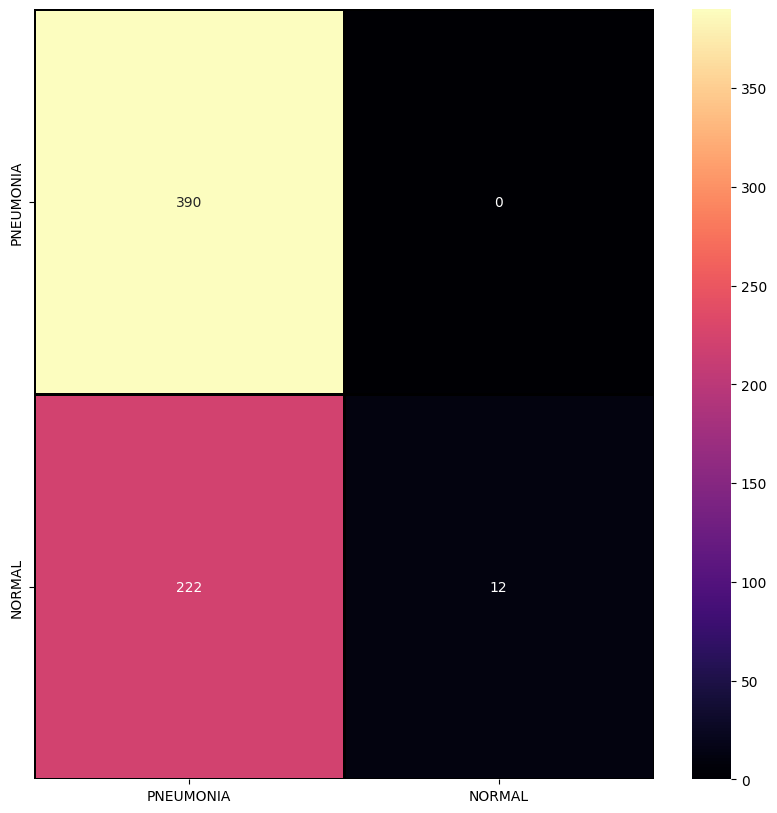

In [16]:
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, index=["0", "1"], columns=["0", "1"])

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="magma", linecolor='black', linewidth=1,
            annot=True, fmt='', xticklabels=labels, yticklabels=labels)